In [2]:
!pip install python-dotenv


In [3]:
from typing import Annotated

from langchain.chat_models import init_chat_model
from typing_extensions import TypedDict
from langchain.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv

load_dotenv()
#conv history
class ReviewState(TypedDict):
    messages: Annotated[list, add_messages]
    question: str
    user_solution: str
    language: str
    optimized_solution: str
    feedback: str
    detailed_explanation: str
    user_reply: bool


graph_builder = StateGraph(ReviewState)

In [4]:
llm = init_chat_model("google_genai:gemini-2.0-flash-lite")

In [5]:
# 1. Router Agent

def router_agent(state: ReviewState):
    prompt = ChatPromptTemplate.from_template(
        """You are a language detection assistant.
        Analyze the following user solution:
        {user_solution}

        Determine which programming language is used: Python or C++.
        If you cannot detect, return "Unknown".
        **Just output one word**: Python, C++, or Unknown."""
    )
    chain_input = {"user_solution": state["user_solution"]}
    language = llm.invoke(prompt.format(**chain_input)).content.strip().lower()

    state["language"] = language
    print("the language is: ",language)
    state["messages"].append({"role": "assistant", "content": f"Detected language: {language}"})

    if "python" in language:
        return "python_edge"
    elif language in ("c++", "cpp", "c plus plus"):
        return "cpp_edge"
    else:
        print(f"Language not detected! defaulting to python")
        return "python_edge"

In [6]:
# 2. Optimizer agents (python and c++)

def python_Agent(state:ReviewState) -> ReviewState:
    """
    Takes the user question and python code and provides the most optimised solution for that question \
    Only *Python* code is taken as input and optimized python code is put out as output. \


    """
    print("using the python agent\n")
    prompt = ChatPromptTemplate.from_template(
        """ Given this problem and user solution:\n{question}\nUser Solution:\n {user_solution} \n \
            You specialize in writing most optimized python code for the given problem. \
            Write the Python solution with most optimized time and space complexity.\
            **must not return any kind of explanation**\
            only python code must be outputted.
            """
    )
    chain_input = {"question": state["question"], "user_solution": state["user_solution"]}
    optimized_code = llm.invoke(prompt.format(**chain_input)).content

    state["optimized_solution"] = optimized_code
    state["messages"].append({"role": "assistant", "content": optimized_code})
    return state


def cpp_agent(state:ReviewState) -> ReviewState:
    """
    Takes the user question and c++ code and provides the most optimised solution for that question \
    Only *C++* code is taken as input and optimized c++ code is put out as output. \

    """
    print("using the c++ agent\n")
    prompt = ChatPromptTemplate.from_template(
        """
        Given this problem and user solution:\n{question}\nUser Solution:\n {user_solution} \n \
        You specialize in writing most optimized c++ code for the given problem. \
        Write the c++ solution with most optimized time and space complexity.
        **must not return any kind of explanation**\
          only c++ code must be outputted.

        """
    )
    Chain_input = {"question": state["question"], "user_solution": state["user_solution"]}
    optimized_code = llm.invoke(prompt.format(**Chain_input)).content

    state["optimized_solution"] = optimized_code
    state["messages"].append({"role": "assistant", "content": optimized_code})
    return state




In [7]:
# 3. Review Agent

def review_agent(state: ReviewState):
    """
    Compares user_solution with optimized_solution,
    provides short feedback, and checks user satisfaction.
    """
    print("using the review agent \n")
    prompt = ChatPromptTemplate.from_template(
        """
        You are a code reviewer.
        Compare the user solution and the optimized solution.

        User Solution:
        {user_solution}

        Optimized Solution:
        {optimized_solution}

        Provide a (1-2)lines exlanation :
        - output the full code of both user and optimized solution.
        - provide key inefficiencies in the user solution and (time/space) complexities.
        """
    )
    chain_input = {
        "user_solution": state["user_solution"],
        "optimized_solution": state["optimized_solution"],
    }

    feedback = llm.invoke(prompt.format(**chain_input)).content
    print(feedback)
    state["feedback"] = feedback
    state["messages"].append({"role": "assistant", "content": feedback})

    # Human in the loop (user feedback) wither yes or not
    user_reply = input("\nDo want more explanation (yes/no): ").strip().lower()
    state["messages"].append({"role": "user", "content": user_reply})

    # Step 3: Route based on user satisfaction
    if user_reply.startswith("y"):
        return "explainer_edge"
    else:
        return "end_edge"



In [8]:
# 4. Explainer agent

def explainer_agent(state: ReviewState):
    """
    Provide a detailed explanation comparing user_solution and optimized_solution.
    """
    print("using explainer agent")
    prompt = ChatPromptTemplate.from_template(
        """
        You are a detailed explainer.
        Compare the user solution and optimized solution for the given question:
        {question}

        User Solution:
        {user_solution}

        Optimized Solution:
        {optimized_solution}

        Provide a detailed explanation:
        - Mistakes or inefficiencies in user's code.
        - How the optimized solution improves performance.
        - Any coding best practices that can help the user.
        - explain and provide comparision of the complexities
        """
    )

    chain_input = {
        "question": state["question"],
        "user_solution": state["user_solution"],
        "optimized_solution": state["optimized_solution"],
    }

    explanation = llm.invoke(prompt.format(**chain_input)).content
    state["detailed_explanation"] = explanation
    state["messages"].append({"role": "assistant", "content": explanation})
    return state




In [9]:
# add all the nodes and edges

graph_builder.add_node("router_node", lambda state:state)
graph_builder.add_node("python_node", python_Agent)
graph_builder.add_node("cpp_node", cpp_agent)
graph_builder.add_node("review_node", lambda state:state)
graph_builder.add_node("explainer_node", explainer_agent)

graph_builder.add_edge(START, "router_node")
graph_builder.add_conditional_edges(
    "router_node",
    router_agent,
    {
        "python_edge": "python_node",
        "cpp_edge": "cpp_node",
    },
)
graph_builder.add_edge("python_node", "review_node")
graph_builder.add_edge("cpp_node", "review_node")
graph_builder.add_conditional_edges(
    "review_node",
    review_agent,
    {
        "end_edge": END,
        "explainer_edge": "explainer_node",
    }
)
graph_builder.add_edge("explainer_node", END)

In [10]:
graph = graph_builder.compile()

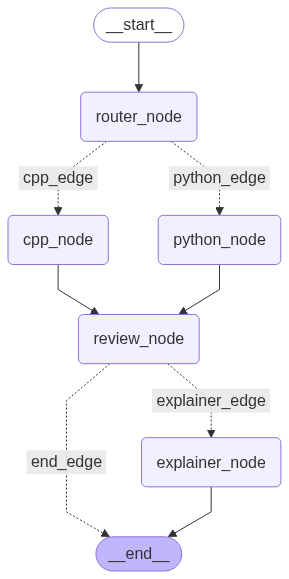

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [12]:
def stream_graph_updates(question: str, user_solution: str):
    """
    Stream updates from the graph for a single user query.
    Passes both question and user_solution into the state.
    """
    initial_state = {
        "question": question,
        "user_solution": user_solution,
        "messages": [
            {"role": "user", "content": f"Question: {question}"},
            {"role": "user", "content": f"User Solution: {user_solution}"}
        ]
    }

    # Stream through LangGraph
    for event in graph.stream(initial_state):
        for value in event.values():
            last_msg = value["messages"][-1]
            # Check if the last message is a dict or LangChain message
            if isinstance(last_msg, dict):
                print("Assistant:", last_msg.get("content", ""))
            else:
                print("Assistant:", last_msg.content)



def start_chat():
    """
    Starts the interactive chat loop.
    Each iteration takes question + user_solution from user.
    """
    print("Welcome to the Code Review Assistant (type 'quit' to exit).")

    while True:
        # Get Question Input
        question = input("\nEnter the LeetCode Question (or 'quit' to exit): ")
        if question.strip().lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        # Get User Solution Input
        user_solution = input("Enter your Solution Code (or 'quit' to exit): ")
        if user_solution.strip().lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        # Run through the graph
        stream_graph_updates(question, user_solution)


if __name__ == "__main__":
    start_chat()


Welcome to the Code Review Assistant (type 'quit' to exit).

Enter the LeetCode Question (or 'quit' to exit): Given an array of integers nums and an integer target, return indices of the two numbers such that they add up to target.
Enter your Solution Code (or 'quit' to exit): def twoSum(nums, target): for i in range(len(nums)): for j in range(i + 1, len(nums)): if nums[i] + nums[j] == target: return [i, j]
the language is:  python
Assistant: User Solution: def twoSum(nums, target): for i in range(len(nums)): for j in range(i + 1, len(nums)): if nums[i] + nums[j] == target: return [i, j]
using the python agent

Assistant: ```python
def twoSum(nums, target):
    nums_map = {}
    for i, num in enumerate(nums):
        complement = target - num
        if complement in nums_map:
            return [nums_map[complement], i]
        nums_map[num] = i
```
using the review agent 

```python
def twoSum(nums, target):
    for i in range(len(nums)):
        for j in range(i + 1, len(nums)):
   

# Example question
Given an array of integers nums and an integer target, return indices of the two numbers such that they add up to target.

def twoSum(nums, target):
    for i in range(len(nums)):
        for j in range(i + 1, len(nums)):
            if nums[i] + nums[j] == target:
                return [i, j]
